# Loading

In [16]:
import tobii_research as tr
from utils import *

def get_tracker():
  all_eyetrackers = tr.find_all_eyetrackers()

  for tracker in all_eyetrackers:
    print("Model: " + tracker.model)
    print("Serial number: " + tracker.serial_number) 
    print(f"Can stream eye images: {tr.CAPABILITY_HAS_EYE_IMAGES in tracker.device_capabilities}")
    print(f"Can stream gaze data: {tr.CAPABILITY_HAS_GAZE_DATA in tracker.device_capabilities}")
    return tracker

tracker = get_tracker()

data, dict = build_dataset(tracker, 'title')

data

Model: Tobii Pro Fusion
Serial number: TPFC6-010203104285
Can stream eye images: True
Can stream gaze data: True
{'device_time_stamp': 966847858, 'system_time_stamp': 318640395592, 'left_gaze_point_on_display_area': (0.4760041832923889, 0.41453608870506287), 'left_gaze_point_in_user_coordinate_system': (-4.527259349822998, 72.99189758300781, 15.925081253051758), 'left_gaze_point_validity': 1, 'left_pupil_diameter': 4.226318359375, 'left_pupil_validity': 1, 'left_gaze_origin_in_user_coordinate_system': (-20.147022247314453, 56.608848571777344, 528.140380859375), 'left_gaze_origin_in_trackbox_coordinate_system': (0.5536983609199524, 0.353951632976532, 0.19488008320331573), 'left_gaze_origin_validity': 1, 'right_gaze_point_on_display_area': (0.14676035940647125, 0.2565484344959259), 'right_gaze_point_in_user_coordinate_system': (-66.64521026611328, 90.49795532226562, 22.296794891357422), 'right_gaze_point_validity': 1, 'right_pupil_diameter': 4.0628204345703125, 'right_pupil_validity': 1,

,device_time_stamp,system_time_stamp,left_gaze_point_on_display_area,left_gaze_point_in_user_coordinate_system,left_gaze_point_validity,left_pupil_diameter,left_pupil_validity,left_gaze_origin_in_user_coordinate_system,left_gaze_origin_in_trackbox_coordinate_system,left_gaze_origin_validity,right_gaze_point_on_display_area,right_gaze_point_in_user_coordinate_system,right_gaze_point_validity,right_pupil_diameter,right_pupil_validity,right_gaze_origin_in_user_coordinate_system,right_gaze_origin_in_trackbox_coordinate_system,right_gaze_origin_validity,type
timestep_1,966847858,318640395592,"(0.4760041832923889, 0.41453608870506287)","(-4.527259349822998, 72.99189758300781, 15.925...",1,4.226318,1,"(-20.147022247314453, 56.608848571777344, 528....","(0.5536983609199524, 0.353951632976532, 0.1948...",1,"(0.14676035940647125, 0.2565484344959259)","(-66.64521026611328, 90.49795532226562, 22.296...",1,4.06282,1,"(40.30193328857422, 47.331974029541016, 527.48...","(0.39455902576446533, 0.37664881348609924, 0.1...",1,title
timestep_2,967356205,318640904034,"(0.22285503149032593, 0.43963319063186646)","(-52.288536071777344, 70.21095275878906, 14.91...",1,4.487366,1,"(-28.18478775024414, 54.34025573730469, 526.78...","(0.5750167369842529, 0.35938942432403564, 0.19...",1,"(-0.05323377251625061, 0.37219658493995667)","(-104.37781524658203, 77.68338012695312, 17.63...",1,4.350586,1,"(32.422340393066406, 46.86741256713867, 525.94...","(0.41499054431915283, 0.37749841809272766, 0.1...",1,title
timestep_3,967356205,318640904034,"(0.22285503149032593, 0.43963319063186646)","(-52.288536071777344, 70.21095275878906, 14.91...",1,4.487366,1,"(-28.18478775024414, 54.34025573730469, 526.78...","(0.5750167369842529, 0.35938942432403564, 0.19...",1,"(-0.05323377251625061, 0.37219658493995667)","(-104.37781524658203, 77.68338012695312, 17.63...",1,4.350586,1,"(32.422340393066406, 46.86741256713867, 525.94...","(0.41499054431915283, 0.37749841809272766, 0.1...",1,title
timestep_4,968372916,318641920634,"(1.1192240715026855, 0.4275650978088379)","(116.82809448242188, 71.5481948852539, 15.3996...",1,4.425842,1,"(-25.271411895751953, 51.98392105102539, 525.3...","(0.5675329566001892, 0.3649353086948395, 0.188...",1,"(0.8588505387306213, 0.3315219581127167)","(67.70380401611328, 82.19039916992188, 19.2730...",1,4.196304,1,"(35.600494384765625, 44.26944351196289, 526.02...","(0.40659284591674805, 0.384123295545578, 0.189...",1,title
timestep_5,968889605,318642437729,"(0.9064992666244507, 1.0007013082504272)","(76.69361877441406, 8.040943145751953, -7.7151...",1,4.342621,1,"(-24.80845832824707, 51.34747314453125, 526.59...","(0.5661299228668213, 0.3669070601463318, 0.190...",1,"(0.5627926588058472, 1.0189566612243652)","(11.846996307373047, 6.018138885498047, -8.451...",1,4.166229,1,"(35.76268768310547, 43.42695236206055, 526.979...","(0.406355619430542, 0.38652244210243225, 0.190...",1,title
timestep_6,969406293,318642953841,"(0.8931665420532227, 0.9759272336959839)","(74.17814636230469, 10.7860746383667, -6.71593...",1,4.489594,1,"(-25.29100227355957, 50.89128875732422, 526.50...","(0.5674120783805847, 0.36804673075675964, 0.19...",1,"(0.6060754656791687, 1.040907621383667)","(20.013105392456055, 3.585815906524658, -9.336...",1,4.336929,1,"(35.3684196472168, 43.04154968261719, 526.8522...","(0.40736424922943115, 0.3874771296977997, 0.19...",1,title
timestep_7,969906316,318643454005,"(1.104648232460022, 0.5631139874458313)","(114.07809448242188, 56.52848434448242, 9.9329...",1,4.442154,1,"(-24.594974517822266, 51.23181915283203, 526.2...","(0.5656185746192932, 0.36709311604499817, 0.18...",1,"(0.8347840309143066, 0.5349425673484802)","(63.1632194519043, 59.650062561035156, 11.0690...",1,4.119354,1,"(36.22637176513672, 43.465919494628906, 526.58...","(0.4050518274307251, 0.3863155245780945, 0.190...",1,title
timestep_8,970406342,318643953982,"(1.0458738803863525, 0.5785520076751709)","(102.98921966552734, 54.817848205566406, 9.310...",1,4.539902,1,"(-24.3011589

In [2]:
import time

def gaze_data_callback(gaze_data):
  global global_gaze_data
  global_gaze_data = gaze_data
  
def gaze_data(eyetracker, wait_time=5):
  global global_gaze_data

  print("Getting data...")
  eyetracker.subscribe_to(tr.EYETRACKER_GAZE_DATA, gaze_data_callback, as_dictionary=True)

  time.sleep(wait_time)

  eyetracker.unsubscribe_from(tr.EYETRACKER_GAZE_DATA, gaze_data_callback)

  return global_gaze_data
  
data = gaze_data(tracker)
data

Getting data...


{'device_time_stamp': 1224775335,
 'system_time_stamp': 68835709412,
 'left_gaze_point_on_display_area': (nan, nan),
 'left_gaze_point_in_user_coordinate_system': (nan, nan, nan),
 'left_gaze_point_validity': 0,
 'left_pupil_diameter': nan,
 'left_pupil_validity': 0,
 'left_gaze_origin_in_user_coordinate_system': (nan, nan, nan),
 'left_gaze_origin_in_trackbox_coordinate_system': (nan, nan, nan),
 'left_gaze_origin_validity': 0,
 'right_gaze_point_on_display_area': (nan, nan),
 'right_gaze_point_in_user_coordinate_system': (nan, nan, nan),
 'right_gaze_point_validity': 0,
 'right_pupil_diameter': nan,
 'right_pupil_validity': 0,
 'right_gaze_origin_in_user_coordinate_system': (nan, nan, nan),
 'right_gaze_origin_in_trackbox_coordinate_system': (nan, nan, nan),
 'right_gaze_origin_validity': 0}

# Visualizations

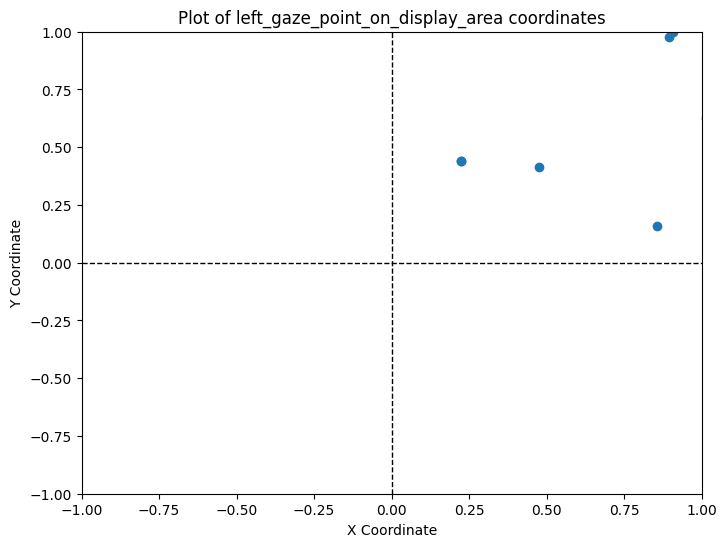

In [21]:
from matplotlib import pyplot as plt

# plot coordinates (you can use this for testing or for funsies)
# takes in a dataframe (call build_dataset first)
#          and a column_name (string)

def plot_coordinates(dataframe, column_name):
    # extract x and y coordinates from the specified column
    x_values = [point[0] for point in dataframe[column_name]]
    y_values = [point[1] for point in dataframe[column_name]]

    # plot the coordinates
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, marker='o', label=column_name)
    plt.title(f'Plot of {column_name} coordinates')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    plt.show()
    
plot_coordinates(data, 'left_gaze_point_on_display_area')


# Make eye detection functions

In [37]:
# example
# function should accept a dictionary of gaze data (look at what the gaze_data function returns)
# when we call build_dataset, we also make a call to gaze_data, so we'll be able to 
# modify build_dataset to check for movement detection at every timestep.


def detect_movement_example(data_dict):
    # data_dict should only have 1 row
    assert(len(data_dict) == 1)  # remove this in practice, just keeping it here for initial testing
    
    # get the first (and only) row in data_dict
    eye_data = data_dict.iloc[0]
    
    # get eye coordinates
    left_x, left_y = data.left_gaze_point_on_display_area[0]
    right_x, right_y = data.right_gaze_point_on_display_area[0]
    
    # do some kind of detection
    print(left_x)
    return (left_x >= 0)
    
# test your function
data2 = pd.DataFrame(data.iloc[0]).transpose()  # call build_dataset and get a row
detect_movement_example(data2)                  # call detect_movement


0.4760041832923889


True

In [ ]:
# try incorporating your function into a modified build_dataset, 
# so you can test your movement detection function while recording data

# make modifications here:
def modified_build_dataset(tracker, label, add_on = False, df_orig = pd.DataFrame(), 
                  time_step_sec = 0.5, tot_time_min = 0.1):
    
    global global_gaze_data
    
    intervals = math.ceil((tot_time_min * 60) / time_step_sec)
    dict_list = []
    
    for _ in range(intervals):
        data = gaze_data(tracker, time_step_sec)
        dict_list.append(data)
    
    tot_dict = combine_dicts_with_labels(dict_list)
    df = pd.DataFrame(tot_dict).T
    df['type'] = label
        
    if add_on:
        df_new = pd.concat([df_orig, df])
        df_new = df_new.reset_index(drop=True)
        return df_new
    
    else:
        return df, dict_list